In [8]:
# =========================
# Weighted Propensity Score Matching (PSM) by Bottom50
# Weights used in both propensity scores and ATE
# =========================
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---- 0) Load data ----
ces = pd.read_csv("CES_RF_SMT_Dummies.csv")

TREATMENT = "Second_Moment_Treatment"
OUTCOME = "lc_w13"
DUMMY = "Bottom50"
COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---- Clean subset ----
used_cols = [TREATMENT, OUTCOME, "wgt", DUMMY] + COVARIATES
ces_ = ces.dropna(subset=used_cols).copy()
X = ces_[COVARIATES]
T = ces_[TREATMENT].astype(int).values
Y = ces_[OUTCOME].astype(float).values
w = ces_["wgt"].astype(float).values
dummy = ces_[DUMMY].astype(int).values

# Standardize covariates
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# =========================
# 1) Propensity score estimation (weighted logistic regression)
# =========================
logit = LogisticRegression(max_iter=1000)
logit.fit(X_scaled, T, sample_weight=w)
prop_scores = logit.predict_proba(X_scaled)[:, 1]

# =========================
# 2) Nearest-neighbor matching function (1:1, no replacement)
# =========================
def match_psm(T, prop_scores):
    treated_idx = np.where(T == 1)[0]
    control_idx = np.where(T == 0)[0]
    matched_control_idx = []
    used_controls = set()
    for i in treated_idx:
        available = [c for c in control_idx if c not in used_controls]
        if not available:
            break
        distances = np.abs(prop_scores[available] - prop_scores[i])
        closest = available[np.argmin(distances)]
        matched_control_idx.append(closest)
        used_controls.add(closest)
    treated_matched = treated_idx[:len(matched_control_idx)]
    control_matched = np.array(matched_control_idx)
    return treated_matched, control_matched

# =========================
# 3) Weighted bootstrap ATE function
# =========================
def bootstrap_ate_psm(Y_t, Y_c, w_t, w_c, n_boot=500):
    np.random.seed(42)
    ates = []
    n_pairs = len(Y_t)
    for _ in range(n_boot):
        idx = np.random.choice(n_pairs, n_pairs, replace=True)
        ate_b = np.average(Y_t[idx], weights=w_t[idx]) - np.average(Y_c[idx], weights=w_c[idx])
        ates.append(ate_b)
    return np.mean(ates), np.std(ates)

# =========================
# 4) Compute population-representative ATEs by Bottom50
# =========================
for val in [0, 1]:
    subset_idx = np.where(dummy == val)[0]
    T_sub = T[subset_idx]
    Y_sub = Y[subset_idx]
    w_sub = w[subset_idx]
    prop_sub = prop_scores[subset_idx]

    treated_matched, control_matched = match_psm(T_sub, prop_sub)

    Y_treated = Y_sub[treated_matched]
    Y_control = Y_sub[control_matched]
    w_treated = w_sub[treated_matched]
    w_control = w_sub[control_matched]

    ate_mean, ate_se = bootstrap_ate_psm(Y_treated, Y_control, w_treated, w_control)
    print(f"Bottom50 = {val} -> Population-representative ATE: {ate_mean:.4f}, SE: {ate_se:.4f}")


Bottom50 = 0 -> Population-representative ATE: 0.0333, SE: 0.0394
Bottom50 = 1 -> Population-representative ATE: 0.0998, SE: 0.0393


In [4]:
# ================================
# IPW ATE estimator by Bottom50
# ================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# ---- 0) Load data and setup ----
ces = pd.read_csv("CES_RF_SMT_Dummies.csv")

TREATMENT = "Second_Moment_Treatment"   # 1 = treatment, 0 = control
OUTCOME   = "lc_w13"                    # outcome
WEIGHT    = "wgt"                       # survey weight
DUMMY     = "Bottom50"

COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# Keep only needed columns and drop missing
keep_cols = [TREATMENT, OUTCOME, WEIGHT, DUMMY] + COVARIATES
ces = ces[keep_cols].dropna().copy()

# Ensure correct dtypes
ces[TREATMENT] = ces[TREATMENT].astype(int)
ces[WEIGHT]    = ces[WEIGHT].astype(float)
ces[DUMMY]     = ces[DUMMY].astype(int)
for v in COVARIATES:
    ces[v] = ces[v].astype(float)

T = ces[TREATMENT].values
Y = ces[OUTCOME].values
w = ces[WEIGHT].values
X = ces[COVARIATES].values
dummy = ces[DUMMY].values

n = len(Y)
print(f"Sample size after dropping NAs: {n}")

# ---- 1) Function to compute IPW ATE ----
def ipw_ate(T, Y, w, X):
    # Fit weighted logistic regression for propensity scores
    ps_model = LogisticRegression(max_iter=1000, solver="lbfgs")
    ps_model.fit(X, T, sample_weight=w)
    ps_raw = ps_model.predict_proba(X)[:, 1]
    EPS = 1e-4
    ps = np.clip(ps_raw, EPS, 1 - EPS)

    # IPW score
    ipw_score = T * Y / ps - (1 - T) * Y / (1 - ps)

    # Weighted ATE
    ate = np.sum(w * ipw_score) / np.sum(w)

    # Weighted SE using influence function
    psi = ipw_score - ate
    var_ate = np.sum(w * psi**2) / (np.sum(w)**2)
    se = np.sqrt(var_ate)

    return ate, se

# ---- 2) Compute IPW ATEs by Bottom50 ----
for val in [0, 1]:
    idx = np.where(dummy == val)[0]
    T_sub = T[idx]
    Y_sub = Y[idx]
    w_sub = w[idx]
    X_sub = X[idx]

    ate_val, se_val = ipw_ate(T_sub, Y_sub, w_sub, X_sub)
    print(f"Bottom50 = {val} -> Population-representative IPW ATE: {ate_val:.6f}, SE: {se_val:.6f}")


Sample size after dropping NAs: 2571
Bottom50 = 0 -> Population-representative IPW ATE: 0.031628, SE: 0.002800
Bottom50 = 1 -> Population-representative IPW ATE: 0.070279, SE: 0.002637


Full sample IPW ATE (weighted) = 0.045696
95% CI = [-0.011992, 0.105407]


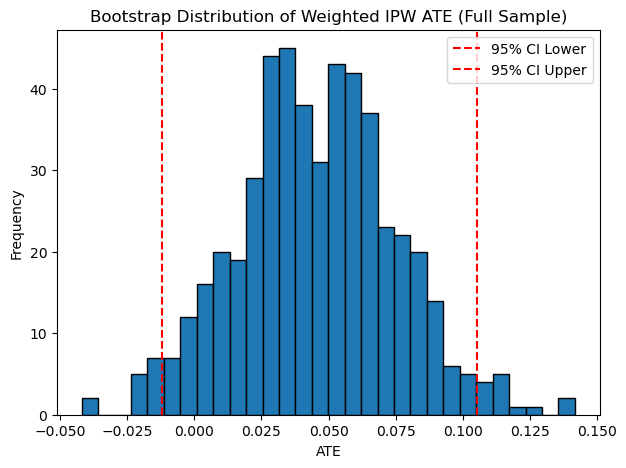

Bottom50 = 0 -> IPW ATE: 0.031815, 95% CI: [-0.061535, 0.122526]


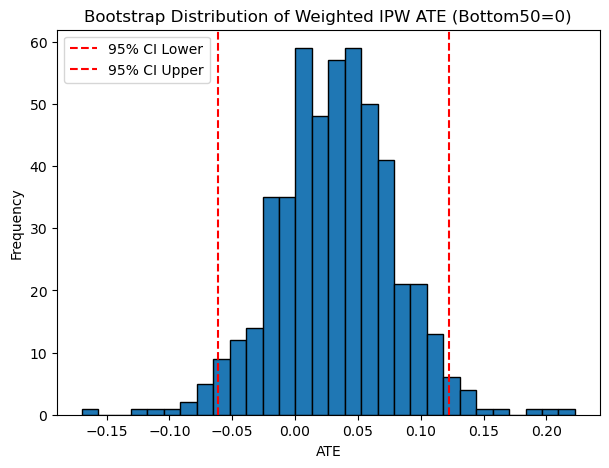

Bottom50 = 1 -> IPW ATE: 0.072756, 95% CI: [-0.025284, 0.182513]


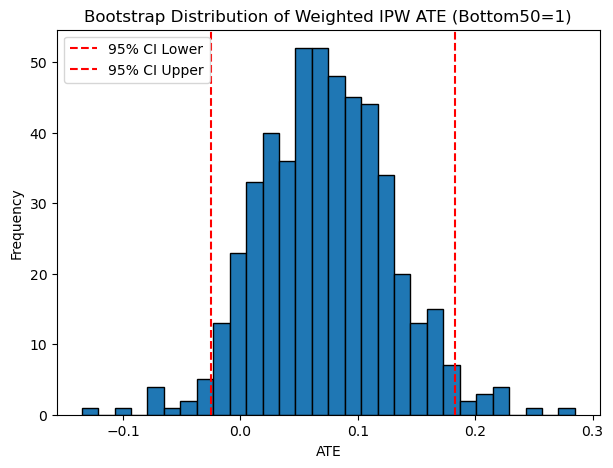

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# ---- Load new dataset ----
ces = pd.read_csv("CES_RF_SMT_Dummies.csv")

TREATMENT = "Second_Moment_Treatment"
OUTCOME   = "lc_w13"
WGT       = "wgt"
DUMMY     = "Bottom50"

# Covariates without household income
COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# Clean NAs
ces = ces.dropna(subset=[TREATMENT, OUTCOME, WGT, DUMMY] + COVARIATES)

# --- Helper: compute weighted IPW ATE on a given sample -----------------
def compute_weighted_ipw_ate(df):
    X = df[COVARIATES]
    T = df[TREATMENT].astype(int).values
    Y = df[OUTCOME].astype(float).values
    w = df[WGT].astype(float).values

    # Weighted propensity model
    ps_model = LogisticRegression(max_iter=1000, solver="lbfgs")
    ps_model.fit(X, T, sample_weight=w)
    e = ps_model.predict_proba(X)[:, 1]
    e = np.clip(e, 1e-3, 1-1e-3)

    # Stabilized IPW weights
    p_t = np.average(T, weights=w)
    ipw = np.where(T == 1, p_t / e, (1 - p_t) / (1 - e))

    # Weighted stabilized ATE
    expr = ipw * (T * Y / p_t - (1 - T) * Y / (1 - p_t))
    ate = np.average(expr, weights=w)
    return ate

# --- Bootstrap helper function -----------------------------------------
def bootstrap_ipw(df, n_boot=500, random_seed=42):
    rng = np.random.default_rng(random_seed)
    boot_ates = []
    for _ in range(n_boot):
        samp = df.sample(frac=1.0, replace=True, random_state=rng.integers(0, 1_000_000))
        ate_b = compute_weighted_ipw_ate(samp)
        boot_ates.append(ate_b)
    boot_arr = np.array(boot_ates)
    ci_low, ci_high = np.percentile(boot_arr, [2.5, 97.5])
    return boot_arr.mean(), ci_low, ci_high, boot_arr

# --- 1) Full-sample weighted IPW ATE -----------------------------------
ate_full, ci_low, ci_high, boot_arr_full = bootstrap_ipw(ces)
print(f"Full sample IPW ATE (weighted) = {ate_full:.6f}")
print(f"95% CI = [{ci_low:.6f}, {ci_high:.6f}]")

plt.figure(figsize=(7,5))
plt.hist(boot_arr_full, bins=30, edgecolor="black")
plt.axvline(ci_low, linestyle="--", color="red", label="95% CI Lower")
plt.axvline(ci_high, linestyle="--", color="red", label="95% CI Upper")
plt.title("Bootstrap Distribution of Weighted IPW ATE (Full Sample)")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- 2) Weighted IPW ATE by Bottom50 -----------------------------------
for val in [0, 1]:
    subset = ces[ces[DUMMY] == val]
    ate, ci_low, ci_high, boot_arr = bootstrap_ipw(subset)
    print(f"Bottom50 = {val} -> IPW ATE: {ate:.6f}, 95% CI: [{ci_low:.6f}, {ci_high:.6f}]")

    plt.figure(figsize=(7,5))
    plt.hist(boot_arr, bins=30, edgecolor="black")
    plt.axvline(ci_low, linestyle="--", color="red", label="95% CI Lower")
    plt.axvline(ci_high, linestyle="--", color="red", label="95% CI Upper")
    plt.title(f"Bootstrap Distribution of Weighted IPW ATE (Bottom50={val})")
    plt.xlabel("ATE")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [2]:
# single-file copy-paste block
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# ---- settings ----
DATA_PATH = "CES_RF_SMT_Dummies.csv"
TREATMENT = "Second_Moment_Treatment"
OUTCOME   = "lc_w13"
WGT       = "wgt"
DUMMY     = "Bottom50"

COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---- load and clean ----
df = pd.read_csv(DATA_PATH)
used_cols = [TREATMENT, OUTCOME, WGT, DUMMY] + COVARIATES
df = df.dropna(subset=used_cols).copy()

X_df = df[COVARIATES].copy()
T_arr = df[TREATMENT].astype(int).values
Y_arr = df[OUTCOME].astype(float).values
w_arr = df[WGT].astype(float).values
dummy_arr = df[DUMMY].astype(int).values

# ---- helper: one weighted bootstrap function (pandas-based, like earlier) ----
def _weighted_bootstrap_learner(X_df, T, Y, w, model_fn, n_boot=200, learner="S", seed=42):
    """
    Weighted bootstrap similar to your original implementation:
    - resample indices with probability proportional to w
    - fit model(s) inside each bootstrap
    - compute tau for each observation in bootstrap sample
    - return mean and std of weighted average(tau) across bootstraps, and the bootstrap array
    """
    np.random.seed(seed)
    n = len(Y)
    probs = w / w.sum()
    boot_ates = []

    for b in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True, p=probs)
        X_b = X_df.iloc[idx].reset_index(drop=True)
        T_b = T[idx]
        Y_b = Y[idx]
        w_b = w[idx]

        if learner == "S":
            Xs = X_b.copy()
            Xs["_T"] = T_b
            model = model_fn()
            model.fit(Xs, Y_b, sample_weight=w_b)
            X0 = X_b.copy(); X0["_T"] = 0
            X1 = X_b.copy(); X1["_T"] = 1
            tau_b = model.predict(X1) - model.predict(X0)

        elif learner == "T":
            m0 = model_fn(); m1 = model_fn()
            # fit only if group exists in bootstrap sample
            if (T_b == 0).sum() > 0:
                m0.fit(X_b[T_b==0], Y_b[T_b==0], sample_weight=w_b[T_b==0])
            if (T_b == 1).sum() > 0:
                m1.fit(X_b[T_b==1], Y_b[T_b==1], sample_weight=w_b[T_b==1])
            # predict on all rows in bootstrap sample
            pred1 = m1.predict(X_b) if (T_b==1).sum() > 0 else np.zeros(len(X_b))
            pred0 = m0.predict(X_b) if (T_b==0).sum() > 0 else np.zeros(len(X_b))
            tau_b = pred1 - pred0

        elif learner == "X":
            # Fit m0, m1 on bootstrap sample
            m0 = model_fn(); m1 = model_fn()
            if (T_b == 0).sum() > 0:
                m0.fit(X_b[T_b==0], Y_b[T_b==0], sample_weight=w_b[T_b==0])
            if (T_b == 1).sum() > 0:
                m1.fit(X_b[T_b==1], Y_b[T_b==1], sample_weight=w_b[T_b==1])

            # D1 (for units with T=1) and D0 (for units with T=0)
            pred0_on1 = m0.predict(X_b[T_b==1]) if (T_b==1).sum() > 0 else np.array([])
            pred1_on0 = m1.predict(X_b[T_b==0]) if (T_b==0).sum() > 0 else np.array([])

            D1 = Y_b[T_b==1] - pred0_on1 if (T_b==1).sum() > 0 else np.array([])
            D0 = pred1_on0 - Y_b[T_b==0] if (T_b==0).sum() > 0 else np.array([])

            # train g0 on (T==0, D0) and g1 on (T==1, D1)
            tau_hat0 = np.zeros(len(X_b))
            tau_hat1 = np.zeros(len(X_b))

            if (T_b==0).sum() > 0:
                g0 = model_fn()
                g0.fit(X_b[T_b==0], D0, sample_weight=w_b[T_b==0])
                tau_hat0 = g0.predict(X_b)
            if (T_b==1).sum() > 0:
                g1 = model_fn()
                g1.fit(X_b[T_b==1], D1, sample_weight=w_b[T_b==1])
                tau_hat1 = g1.predict(X_b)

            p_t = float(np.average(T_b, weights=w_b))
            tau_b = p_t * tau_hat0 + (1 - p_t) * tau_hat1

        else:
            raise ValueError("Unknown learner")

        # weighted average of tau_b using weights in this bootstrap sample
        boot_ates.append(np.average(tau_b, weights=w_b))

    boot_arr = np.array(boot_ates)
    return boot_arr.mean(), boot_arr.std(ddof=1), boot_arr

# ---- wrappers for each meta-learner ----
def compute_S_learner(X_df, T, Y, w, n_boot=200, model_params=None):
    model_params = model_params or {}
    def model_fn(): 
        return GradientBoostingRegressor(random_state=42, **model_params)
    ate, se, boot = _weighted_bootstrap_learner(X_df, T, Y, w, model_fn, n_boot=n_boot, learner="S")
    return ate, se, boot

def compute_T_learner(X_df, T, Y, w, n_boot=200, model_params=None):
    model_params = model_params or {}
    def model_fn(): 
        return GradientBoostingRegressor(random_state=42, **model_params)
    ate, se, boot = _weighted_bootstrap_learner(X_df, T, Y, w, model_fn, n_boot=n_boot, learner="T")
    return ate, se, boot

def compute_X_learner(X_df, T, Y, w, n_boot=200, model_params=None):
    model_params = model_params or {}
    def model_fn(): 
        return GradientBoostingRegressor(random_state=42, **model_params)
    ate, se, boot = _weighted_bootstrap_learner(X_df, T, Y, w, model_fn, n_boot=n_boot, learner="X")
    return ate, se, boot

# ---- Example usage: full sample ----
print("Running on full sample (this can take a bit)...")
model_params = {"n_estimators": 200, "max_depth": 3}  # lighter/faster defaults for exploration

ate_s, se_s, boot_s = compute_S_learner(X_df, T_arr, Y_arr, w_arr, n_boot=200, model_params=model_params)
print(f"S-learner ATE: {ate_s:.6f}, SE: {se_s:.6f}")

ate_t, se_t, boot_t = compute_T_learner(X_df, T_arr, Y_arr, w_arr, n_boot=200, model_params=model_params)
print(f"T-learner ATE: {ate_t:.6f}, SE: {se_t:.6f}")

ate_x, se_x, boot_x = compute_X_learner(X_df, T_arr, Y_arr, w_arr, n_boot=200, model_params=model_params)
print(f"X-learner ATE: {ate_x:.6f}, SE: {se_x:.6f}")

# ---- Example usage: by Bottom50 subgroup ----
for val in [0,1]:
    idx = np.where(dummy_arr == val)[0]
    print(f"\nBottom50 = {val} (n = {len(idx)})")
    X_sub = X_df.iloc[idx]
    T_sub = T_arr[idx]
    Y_sub = Y_arr[idx]
    w_sub = w_arr[idx]

    ate_s, se_s, _ = compute_S_learner(X_sub, T_sub, Y_sub, w_sub, n_boot=200, model_params=model_params)
    ate_t, se_t, _ = compute_T_learner(X_sub, T_sub, Y_sub, w_sub, n_boot=200, model_params=model_params)
    ate_x, se_x, _ = compute_X_learner(X_sub, T_sub, Y_sub, w_sub, n_boot=200, model_params=model_params)

    print(f"S: {ate_s:.6f} (SE {se_s:.6f}), T: {ate_t:.6f} (SE {se_t:.6f}), X: {ate_x:.6f} (SE {se_x:.6f})")


Running on full sample (this can take a bit)...
S-learner ATE: 0.031649, SE: 0.015687
T-learner ATE: 0.041739, SE: 0.021031
X-learner ATE: 0.048682, SE: 0.020160

Bottom50 = 0 (n = 1278)
S: 0.028012 (SE 0.018767), T: -0.003650 (SE 0.032055), X: 0.002629 (SE 0.029915)

Bottom50 = 1 (n = 1293)
S: 0.048848 (SE 0.023473), T: 0.096741 (SE 0.030383), X: 0.088414 (SE 0.028415)


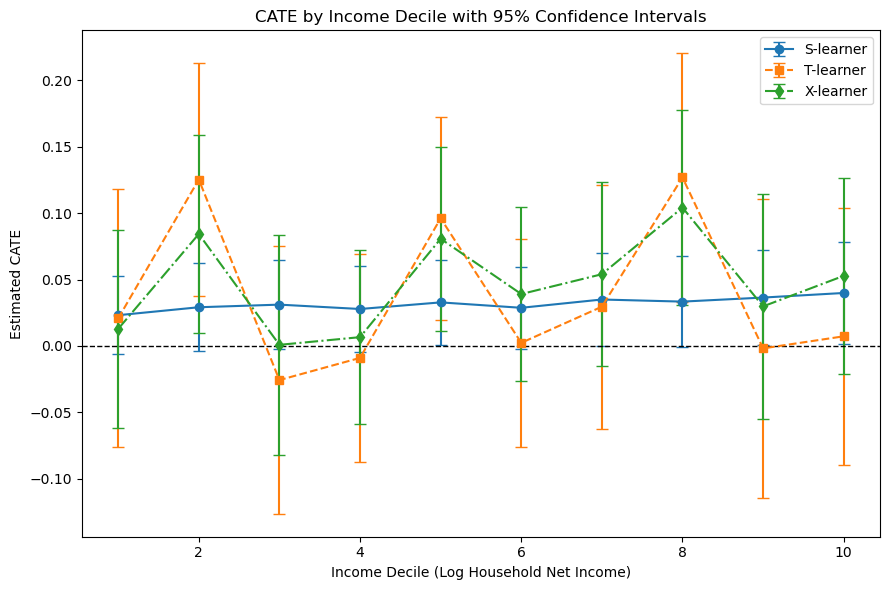

In [1]:
# ============================================================
# CATE(x) by income percentile for S-, T-, and X-learners
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

# -----------------------
# SETTINGS
# -----------------------
DATA_PATH = "CES_RF_SMT_Dummies.csv"
TREATMENT = "Second_Moment_Treatment"
OUTCOME   = "lc_w13"
WGT       = "wgt"
INCOME    = "Log_Household_Net_Income"

COVARIATES = [
    "Highschool_Educated", "Tertiary_Educated",
    "Age", "age2", "Household_Size", "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D", "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

MODEL_PARAMS = {"n_estimators": 200, "max_depth": 3}
N_BOOT = 200
SEED = 42

# -----------------------
# LOAD + PREP
# -----------------------
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TREATMENT, OUTCOME, WGT, INCOME] + COVARIATES).copy()

df["income_decile"] = pd.qcut(df[INCOME], q=10, labels=False) + 1

X = df[COVARIATES]
T = df[TREATMENT].astype(int).values
Y = df[OUTCOME].values
w = df[WGT].values

# ============================================================
# INDIVIDUAL-LEVEL CATE ESTIMATORS
# ============================================================

def cate_S(X, T, Y, w):
    Xs = X.copy()
    Xs["_T"] = T
    m = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    m.fit(Xs, Y, sample_weight=w)
    X0 = X.copy(); X0["_T"] = 0
    X1 = X.copy(); X1["_T"] = 1
    return m.predict(X1) - m.predict(X0)

def cate_T(X, T, Y, w):
    m0 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    m1 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    m0.fit(X[T==0], Y[T==0], sample_weight=w[T==0])
    m1.fit(X[T==1], Y[T==1], sample_weight=w[T==1])
    return m1.predict(X) - m0.predict(X)

def cate_X(X, T, Y, w):
    m0 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    m1 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    m0.fit(X[T==0], Y[T==0], sample_weight=w[T==0])
    m1.fit(X[T==1], Y[T==1], sample_weight=w[T==1])

    D1 = Y[T==1] - m0.predict(X[T==1])
    D0 = m1.predict(X[T==0]) - Y[T==0]

    g1 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    g0 = GradientBoostingRegressor(random_state=SEED, **MODEL_PARAMS)
    g1.fit(X[T==1], D1, sample_weight=w[T==1])
    g0.fit(X[T==0], D0, sample_weight=w[T==0])

    p = np.average(T, weights=w)
    return p * g0.predict(X) + (1 - p) * g1.predict(X)

# ============================================================
# BOOTSTRAP CATE BY DECILE
# ============================================================

def bootstrap_cate(df, cate_fn):
    np.random.seed(SEED)
    out = []

    probs = df[WGT] / df[WGT].sum()

    for _ in range(N_BOOT):
        idx = np.random.choice(len(df), size=len(df), replace=True, p=probs)
        d = df.iloc[idx].reset_index(drop=True)

        tau = cate_fn(
            d[COVARIATES],
            d[TREATMENT].values,
            d[OUTCOME].values,
            d[WGT].values
        )
        d["tau"] = tau

        g = (
            d.groupby("income_decile")
            .apply(lambda x: np.average(x["tau"], weights=x[WGT]))
        )
        out.append(g)

    boot = pd.concat(out, axis=1)
    return boot.mean(axis=1), boot.std(axis=1)

# -----------------------
# RUN ALL THREE LEARNERS
# -----------------------
mean_S, se_S = bootstrap_cate(df, cate_S)
mean_T, se_T = bootstrap_cate(df, cate_T)
mean_X, se_X = bootstrap_cate(df, cate_X)

# ============================================================
# PLOT
# ============================================================

plt.figure(figsize=(9,6))

dec = mean_S.index.values

plt.errorbar(dec, mean_S, yerr=1.96*se_S, fmt="o-", capsize=4, label="S-learner")
plt.errorbar(dec, mean_T, yerr=1.96*se_T, fmt="s--", capsize=4, label="T-learner")
plt.errorbar(dec, mean_X, yerr=1.96*se_X, fmt="d-.", capsize=4, label="X-learner")

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Income Decile (Log Household Net Income)")
plt.ylabel("Estimated CATE")
plt.title("CATE by Income Decile with 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ---------- UPDATED crossfit_aipw_indices (returns m0, m1) ----------
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from scipy.stats import norm

# ensure reproducibility
K = 5
RANDOM_STATE = 42
EPS = 1e-6

def crossfit_aipw_indices(idx, X_df, T_arr, Y_arr, W_arr, K=5, random_state=42):
    """
    idx: indices of rows to use (np.array)
    returns: dictionary with ate, se, ci_lower, ci_upper, psi, tau_hat, g_hat, m0, m1, W, idx
    """
    X_sub = X_df.iloc[idx].to_numpy()
    T_sub = T_arr[idx]
    Y_sub = Y_arr[idx]
    W_sub = W_arr[idx].astype(float)

    # normalize weights to mean 1 for numerical stability (do same across scripts)
    W_sub = W_sub / W_sub.mean()

    n_sub = len(Y_sub)
    if n_sub == 0:
        raise ValueError("Empty subgroup")

    m1 = np.empty(n_sub, dtype=float)
    m0 = np.empty(n_sub, dtype=float)
    g_hat = np.empty(n_sub, dtype=float)

    # use min(K, n_sub) to avoid errors if subgroup < K
    folds = min(K, n_sub)
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)

    for train_idx, test_idx in kf.split(X_sub):
        X_train_raw = X_sub[train_idx]
        X_test_raw = X_sub[test_idx]
        T_train = T_sub[train_idx]
        Y_train = Y_sub[train_idx]
        W_train = W_sub[train_idx]

        # --- propensity model: scale X then RandomForestClassifier with sample weights
        scaler_p = StandardScaler().fit(X_train_raw)
        X_train_p = scaler_p.transform(X_train_raw)
        X_test_p = scaler_p.transform(X_test_raw)

        prop_clf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=random_state)
        prop_clf.fit(X_train_p, T_train, sample_weight=W_train)
        if hasattr(prop_clf, "predict_proba"):
            g_pred = prop_clf.predict_proba(X_test_p)[:, 1]
        else:
            g_pred = prop_clf.predict(X_test_p).astype(float)
        g_pred = np.clip(g_pred, EPS, 1 - EPS)
        g_hat[test_idx] = g_pred

        # --- outcome model: scale XT (X + T) then GradientBoostingRegressor
        scaler_o = StandardScaler().fit(np.hstack([X_train_raw, T_train.reshape(-1, 1)]))
        XT_train = scaler_o.transform(np.hstack([X_train_raw, T_train.reshape(-1, 1)]))
        XT_test_t1 = scaler_o.transform(np.hstack([X_test_raw, np.ones((len(test_idx), 1))]))
        XT_test_t0 = scaler_o.transform(np.hstack([X_test_raw, np.zeros((len(test_idx), 1))]))

        out_reg = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=random_state)
        out_reg.fit(XT_train, Y_train, sample_weight=W_train)

        m1[test_idx] = out_reg.predict(XT_test_t1)
        m0[test_idx] = out_reg.predict(XT_test_t0)

    # influence function (AIPW)
    psi = (m1 - m0) + (T_sub * (Y_sub - m1) / g_hat) - ((1 - T_sub) * (Y_sub - m0) / (1 - g_hat))

    # weighted ATE (use normalized W_sub)
    sumW = np.sum(W_sub)
    ate_hat = np.sum(W_sub * psi) / sumW

    # weighted variance using W^2 numerator (consistent with your other scripts)
    psi_centered = psi - ate_hat
    var_hat = np.sum((W_sub**2) * (psi_centered**2)) / (sumW**2)
    se = np.sqrt(var_hat)
    ci_lower = ate_hat - norm.ppf(0.975) * se
    ci_upper = ate_hat + norm.ppf(0.975) * se

    tau_hat = m1 - m0

    return {
        "ate": ate_hat,
        "se": se,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "psi": psi,
        "tau_hat": tau_hat,
        "g_hat": g_hat,
        "m0": m0,
        "m1": m1,
        "W": W_sub,
        "idx": idx
    }

# ---------- Run for Full sample and groups (same as before) ----------
groups = [("Full sample", np.arange(n)),
          ("Bottom50=0", np.where(dummy_full == 0)[0]),
          ("Bottom50=1", np.where(dummy_full == 1)[0])]

results = []
for name, idx in groups:
    print(f"\nRunning cross-fitted AIPW for: {name} (n={len(idx)})")
    res = crossfit_aipw_indices(idx, X_df, T_full, Y_full, W_full, K=K, random_state=RANDOM_STATE)
    print(f"{name} -> ATE: {res['ate']:.6f}, SE: {res['se']:.6f}, 95% CI: [{res['ci_lower']:.6f}, {res['ci_upper']:.6f}]")
    # diagnostics
    print(f"  sum(W)={res['W'].sum():.3f}, mean(g_hat)={res['g_hat'].mean():.4f}, p_t (weighted)={(np.average(T_full[idx], weights=res['W'])):.4f}")
    results.append((name, res))

# save full-sample residuals (now m0 & m1 exist)
full_res = results[0][1]
full_idx = full_res["idx"]
out_df = df.iloc[full_idx].copy().reset_index(drop=True)
out_df["m0"] = full_res["m0"]
out_df["m1"] = full_res["m1"]
out_df["tau_hat"] = full_res["tau_hat"]
out_df["psi"] = full_res["psi"]
out_df["g_hat"] = full_res["g_hat"]
out_df.to_csv("aipw_crossfit_full_residuals.csv", index=False)
print("Saved full-sample residuals to: aipw_crossfit_full_residuals.csv")



Running cross-fitted AIPW for: Full sample (n=2571)
Full sample -> ATE: 0.032596, SE: 0.027441, 95% CI: [-0.021188, 0.086379]
  sum(W)=2571.000, mean(g_hat)=0.4906, p_t (weighted)=0.4901

Running cross-fitted AIPW for: Bottom50=0 (n=1278)
Bottom50=0 -> ATE: 0.031303, SE: 0.044972, 95% CI: [-0.056839, 0.119446]
  sum(W)=1278.000, mean(g_hat)=0.4819, p_t (weighted)=0.4764

Running cross-fitted AIPW for: Bottom50=1 (n=1293)
Bottom50=1 -> ATE: 0.077822, SE: 0.038328, 95% CI: [0.002699, 0.152944]
  sum(W)=1293.000, mean(g_hat)=0.5017, p_t (weighted)=0.5034
Saved full-sample residuals to: aipw_crossfit_full_residuals.csv


In [11]:
# double_ml_linear_bottom50_savepdf.py
# Linear Double ML (cross-fitted) estimator with weighted cumulative gain plot
# Split by Bottom50 dummy, saving PDF outputs

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

# ---------- USER-SPECIFIED PATH / VARIABLE NAMES ----------
DATA_PATH   = "CES_RF_SMT_Dummies.csv"

TREAT_VAR   = "Second_Moment_Treatment"
OUTCOME_VAR = "lc_w13"
WEIGHT_VAR  = "wgt"
DUMMY_VAR   = "Bottom50"

COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---------- LOAD DATA ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found.")

df = pd.read_csv(DATA_PATH)
required = [TREAT_VAR, OUTCOME_VAR, WEIGHT_VAR, DUMMY_VAR] + COVARIATES
missing = [v for v in required if v not in df.columns]
if missing:
    raise KeyError(f"Missing variables: {missing}")

df = df.dropna(subset=required).reset_index(drop=True)

# ---------- FUNCTION TO RUN DML FOR A SUBSET ----------
def run_linear_dml(sub_df):
    Y = sub_df[OUTCOME_VAR].to_numpy(dtype=float)
    T = sub_df[TREAT_VAR].to_numpy(dtype=float)
    W = sub_df[WEIGHT_VAR].to_numpy(dtype=float)
    X = sub_df[COVARIATES].astype(float).to_numpy()
    
    K = 5
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    m_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, max_depth=6, random_state=1))
    g_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, max_depth=6, random_state=2))
    
    u = np.empty(len(sub_df), dtype=float)
    v = np.empty(len(sub_df), dtype=float)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        T_train, T_test = T[train_idx], T[test_idx]
        W_train = W[train_idx]
        
        m_model.fit(X_train, Y_train, **{"randomforestregressor__sample_weight": W_train})
        g_model.fit(X_train, T_train, **{"randomforestclassifier__sample_weight": W_train})
        
        m_hat = m_model.predict(X_test)
        g_step = list(g_model.named_steps.keys())[-1]
        g_estimator = g_model.named_steps[g_step]
        if hasattr(g_estimator, "predict_proba"):
            g_hat = g_model.predict_proba(X_test)[:, 1]
        else:
            g_hat = np.clip(g_model.predict(X_test), 1e-6, 1-1e-6)
        
        u[test_idx] = Y_test - m_hat
        v[test_idx] = T_test - g_hat
    
    # ATE
    S_vv = np.sum(W * (v ** 2))
    S_vu = np.sum(W * v * u)
    beta_hat = S_vu / S_vv
    eps = u - beta_hat * v
    var_hat = np.sum((W ** 2) * (v ** 2) * (eps ** 2)) / (S_vv ** 2)
    se = np.sqrt(var_hat)
    
    # Weighted difference in means
    weighted_mean_treated = np.sum(W[T == 1] * Y[T == 1]) / np.sum(W[T == 1])
    weighted_mean_control = np.sum(W[T == 0] * Y[T == 0]) / np.sum(W[T == 0])
    
    # Pseudo-scores for cumulative gain
    EPS = 1e-8
    tau_pseudo = (v * u) / (v**2 + EPS)
    score_lin = v * u
    pop_mean_score = np.sum(W * score_lin) / np.sum(W)
    scale = beta_hat / (pop_mean_score + EPS)
    normed_score_lin = score_lin * scale
    
    def cumulative_gain(est_tau, influence, weights):
        order = np.argsort(-est_tau)
        sorted_infl = influence[order]
        sorted_w = weights[order]
        cum_w = np.cumsum(sorted_w)
        total_w = np.sum(weights)
        frac = cum_w / total_w
        cum_ate = np.cumsum(sorted_w * sorted_infl) / (cum_w + EPS)
        return frac, cum_ate
    
    frac_lin, cum_ate_lin = cumulative_gain(tau_pseudo, normed_score_lin, W)
    
    def sample_curve(frac, cum_ate, points=200):
        xs = np.linspace(0, 1, points)
        ys = np.empty_like(xs)
        for i, x in enumerate(xs):
            idx = np.searchsorted(frac, x, side='right') - 1
            ys[i] = cum_ate[idx] if idx >= 0 else np.nan
        if np.isnan(ys).all():
            ys[:] = 0.0
        else:
            first_valid = np.where(~np.isnan(ys))[0][0]
            ys[:first_valid] = ys[first_valid]
        return xs, ys
    
    x_lin, y_lin = sample_curve(frac_lin, cum_ate_lin)
    
    return beta_hat, se, x_lin, y_lin, weighted_mean_treated, weighted_mean_control

# ---------- RUN DML BY Bottom50 & SAVE PDF ----------
for dummy_val in [0, 1]:
    print(f"\n===== Bottom50 = {dummy_val} =====")
    sub_df = df[df[DUMMY_VAR] == dummy_val]
    beta_hat, se, x_lin, y_lin, mean_treat, mean_ctrl = run_linear_dml(sub_df)
    print(f"Sample size: {len(sub_df)}")
    print(f"ATE estimate: {beta_hat:.6f}")
    print(f"Std. error: {se:.6f}")
    print(f"Weighted means — Treated: {mean_treat:.6f}, Control: {mean_ctrl:.6f}")
    
    plt.figure(figsize=(8,5))
    plt.plot(x_lin, y_lin, linestyle='--', linewidth=1.8)
    plt.xlabel("Fraction of sample targeted (largest predicted pseudo-effect first)")
    plt.ylabel("Cumulative ATE among targeted (weighted)")
    plt.title(f"Cumulative Gain Plot — Linear DML (Bottom50={dummy_val})")
    plt.grid(True)
    plt.tight_layout()
    
    pdf_name = f"cumulative_gain_linear_dml_bottom50_{dummy_val}.pdf"
    plt.savefig(pdf_name)
    plt.close()
    print(f"Saved PDF: {pdf_name}")



===== Bottom50 = 0 =====
Sample size: 1278
ATE estimate: 0.029137
Std. error: 0.039458
Weighted means — Treated: 7.445617, Control: 7.423605
Saved PDF: cumulative_gain_linear_dml_bottom50_0.pdf

===== Bottom50 = 1 =====
Sample size: 1293
ATE estimate: 0.073737
Std. error: 0.035790
Weighted means — Treated: 7.173213, Control: 7.081023
Saved PDF: cumulative_gain_linear_dml_bottom50_1.pdf


In [15]:
# double_ml_nonlinear_bottom50.py
# Non-linear Double ML (cross-fitted) estimator with weighted cumulative gain plot
# Bottom50 = 1 only

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

# ---------- USER-SPECIFIED PATH / VARIABLE NAMES ----------
DATA_PATH   = "CES_RF_SMT_Dummies.csv"

TREAT_VAR   = "Second_Moment_Treatment"
OUTCOME_VAR = "lc_w13"
WEIGHT_VAR  = "wgt"
DUMMY_VAR   = "Bottom50"

COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---------- LOAD DATA ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found.")

df = pd.read_csv(DATA_PATH)
required = [TREAT_VAR, OUTCOME_VAR, WEIGHT_VAR, DUMMY_VAR] + COVARIATES
missing = [v for v in required if v not in df.columns]
if missing:
    raise KeyError(f"Missing variables: {missing}")

df = df.dropna(subset=required).reset_index(drop=True)

# Subset Bottom50 = 1
df_sub = df[df[DUMMY_VAR] == 1].copy()
if df_sub.empty:
    raise ValueError("No observations with Bottom50 = 1.")

# ---------- FUNCTION TO RUN NON-LINEAR DML ----------
def run_nonlinear_dml(sub_df):
    Y = sub_df[OUTCOME_VAR].to_numpy(dtype=float)
    T = sub_df[TREAT_VAR].to_numpy(dtype=float)
    W = sub_df[WEIGHT_VAR].to_numpy(dtype=float)
    X = sub_df[COVARIATES].astype(float).to_numpy()
    
    K = 5
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    # Non-linear learners
    m_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=500, max_depth=8, random_state=1))
    g_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, max_depth=8, random_state=2))
    
    u = np.empty(len(sub_df), dtype=float)
    v = np.empty(len(sub_df), dtype=float)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        T_train, T_test = T[train_idx], T[test_idx]
        W_train = W[train_idx]
        
        m_model.fit(X_train, Y_train, **{"randomforestregressor__sample_weight": W_train})
        g_model.fit(X_train, T_train, **{"randomforestclassifier__sample_weight": W_train})
        
        m_hat = m_model.predict(X_test)
        g_step = list(g_model.named_steps.keys())[-1]
        g_estimator = g_model.named_steps[g_step]
        if hasattr(g_estimator, "predict_proba"):
            g_hat = g_model.predict_proba(X_test)[:, 1]
        else:
            g_hat = np.clip(g_model.predict(X_test), 1e-6, 1-1e-6)
        
        u[test_idx] = Y_test - m_hat
        v[test_idx] = T_test - g_hat
    
    # ATE
    S_vv = np.sum(W * (v ** 2))
    S_vu = np.sum(W * v * u)
    beta_hat = S_vu / S_vv
    eps = u - beta_hat * v
    var_hat = np.sum((W ** 2) * (v ** 2) * (eps ** 2)) / (S_vv ** 2)
    se = np.sqrt(var_hat)
    
    # Weighted means
    weighted_mean_treated = np.sum(W[T == 1] * Y[T == 1]) / np.sum(W[T == 1])
    weighted_mean_control = np.sum(W[T == 0] * Y[T == 0]) / np.sum(W[T == 0])
    
    # Pseudo-scores for cumulative gain
    EPS = 1e-8
    tau_pseudo = (v * u) / (v**2 + EPS)
    score_nl = v * u
    pop_mean_score = np.sum(W * score_nl) / np.sum(W)
    scale = beta_hat / (pop_mean_score + EPS)
    normed_score_nl = score_nl * scale
    
    # Cumulative gain
    order = np.argsort(-tau_pseudo)
    sorted_infl = normed_score_nl[order]
    sorted_w = W[order]
    cum_w = np.cumsum(sorted_w)
    frac = cum_w / np.sum(W)
    cum_ate = np.cumsum(sorted_w * sorted_infl) / (cum_w + EPS)
    
    # Sample curve for plotting
    xs = np.linspace(0, 1, 200)
    ys = np.empty_like(xs)
    for i, x in enumerate(xs):
        idx = np.searchsorted(frac, x, side='right') - 1
        ys[i] = cum_ate[idx] if idx >= 0 else np.nan
    first_valid = np.where(~np.isnan(ys))[0][0]
    ys[:first_valid] = ys[first_valid]
    
    return beta_hat, se, xs, ys, weighted_mean_treated, weighted_mean_control

# ---------- RUN NON-LINEAR DML FOR Bottom50 = 1 ----------
beta_hat, se, x_nl, y_nl, mean_treat, mean_ctrl = run_nonlinear_dml(df_sub)

print(f"Sample size: {len(df_sub)}")
print(f"ATE estimate: {beta_hat:.6f}")
print(f"Std. error: {se:.6f}")
print(f"Weighted means — Treated: {mean_treat:.6f}, Control: {mean_ctrl:.6f}")

plt.figure(figsize=(8,5))
plt.plot(x_nl, y_nl, linestyle='--', linewidth=1.8)
plt.xlabel("Fraction of sample targeted (largest predicted pseudo-effect first)")
plt.ylabel("Cumulative ATE among targeted (weighted)")
plt.title("Cumulative Gain Plot — Non-linear DML (Bottom50=1)")
plt.grid(True)
plt.tight_layout()

pdf_name = "cumulative_gain_nonlinear_dml_bottom50_1.pdf"
plt.savefig(pdf_name)
plt.close()
print(f"Saved PDF: {pdf_name}")


Sample size: 1293
ATE estimate: 0.076304
Std. error: 0.035913
Weighted means — Treated: 7.173213, Control: 7.081023
Saved PDF: cumulative_gain_nonlinear_dml_bottom50_1.pdf


In [16]:
# double_ml_linear_bottom50_1.py
# Linear Double ML (cross-fitted) estimator with weighted cumulative gain plot
# Bottom50 = 1 only

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

# ---------- USER-SPECIFIED PATH / VARIABLE NAMES ----------
DATA_PATH   = "CES_RF_SMT_Dummies.csv"

TREAT_VAR   = "Second_Moment_Treatment"
OUTCOME_VAR = "lc_w13"
WEIGHT_VAR  = "wgt"
DUMMY_VAR   = "Bottom50"

COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    # "Log_Household_Net_Income",  # dropped
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---------- LOAD DATA ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found.")

df = pd.read_csv(DATA_PATH)
required = [TREAT_VAR, OUTCOME_VAR, WEIGHT_VAR, DUMMY_VAR] + COVARIATES
missing = [v for v in required if v not in df.columns]
if missing:
    raise KeyError(f"Missing variables: {missing}")

df = df.dropna(subset=required).reset_index(drop=True)

# Subset Bottom50 = 1
df_sub = df[df[DUMMY_VAR] == 1].copy()
if df_sub.empty:
    raise ValueError("No observations with Bottom50 = 1.")

# ---------- FUNCTION TO RUN LINEAR DML ----------
def run_linear_dml(sub_df):
    Y = sub_df[OUTCOME_VAR].to_numpy(dtype=float)
    T = sub_df[TREAT_VAR].to_numpy(dtype=float)
    W = sub_df[WEIGHT_VAR].to_numpy(dtype=float)
    X = sub_df[COVARIATES].astype(float).to_numpy()
    
    K = 5
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    m_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, max_depth=6, random_state=1))
    g_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, max_depth=6, random_state=2))
    
    u = np.empty(len(sub_df), dtype=float)
    v = np.empty(len(sub_df), dtype=float)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        T_train, T_test = T[train_idx], T[test_idx]
        W_train = W[train_idx]
        
        m_model.fit(X_train, Y_train, **{"randomforestregressor__sample_weight": W_train})
        g_model.fit(X_train, T_train, **{"randomforestclassifier__sample_weight": W_train})
        
        m_hat = m_model.predict(X_test)
        g_step = list(g_model.named_steps.keys())[-1]
        g_estimator = g_model.named_steps[g_step]
        if hasattr(g_estimator, "predict_proba"):
            g_hat = g_model.predict_proba(X_test)[:, 1]
        else:
            g_hat = np.clip(g_model.predict(X_test), 1e-6, 1-1e-6)
        
        u[test_idx] = Y_test - m_hat
        v[test_idx] = T_test - g_hat
    
    # ATE
    S_vv = np.sum(W * (v ** 2))
    S_vu = np.sum(W * v * u)
    beta_hat = S_vu / S_vv
    eps = u - beta_hat * v
    var_hat = np.sum((W ** 2) * (v ** 2) * (eps ** 2)) / (S_vv ** 2)
    se = np.sqrt(var_hat)
    
    # Weighted means
    weighted_mean_treated = np.sum(W[T == 1] * Y[T == 1]) / np.sum(W[T == 1])
    weighted_mean_control = np.sum(W[T == 0] * Y[T == 0]) / np.sum(W[T == 0])
    
    # Pseudo-scores for cumulative gain
    EPS = 1e-8
    tau_pseudo = (v * u) / (v**2 + EPS)
    score_lin = v * u
    pop_mean_score = np.sum(W * score_lin) / np.sum(W)
    scale = beta_hat / (pop_mean_score + EPS)
    normed_score_lin = score_lin * scale
    
    # Cumulative gain
    order = np.argsort(-tau_pseudo)
    sorted_infl = normed_score_lin[order]
    sorted_w = W[order]
    cum_w = np.cumsum(sorted_w)
    frac = cum_w / np.sum(W)
    cum_ate = np.cumsum(sorted_w * sorted_infl) / (cum_w + EPS)
    
    # Sample curve for plotting
    xs = np.linspace(0, 1, 200)
    ys = np.empty_like(xs)
    for i, x in enumerate(xs):
        idx = np.searchsorted(frac, x, side='right') - 1
        ys[i] = cum_ate[idx] if idx >= 0 else np.nan
    first_valid = np.where(~np.isnan(ys))[0][0]
    ys[:first_valid] = ys[first_valid]
    
    return beta_hat, se, xs, ys, weighted_mean_treated, weighted_mean_control

# ---------- RUN LINEAR DML FOR Bottom50 = 1 ----------
beta_hat, se, x_lin, y_lin, mean_treat, mean_ctrl = run_linear_dml(df_sub)

print(f"Sample size: {len(df_sub)}")
print(f"ATE estimate: {beta_hat:.6f}")
print(f"Std. error: {se:.6f}")
print(f"Weighted means — Treated: {mean_treat:.6f}, Control: {mean_ctrl:.6f}")

plt.figure(figsize=(8,5))
plt.plot(x_lin, y_lin, linestyle='--', linewidth=1.8)
plt.xlabel("Fraction of sample targeted (largest predicted pseudo-effect first)")
plt.ylabel("Cumulative ATE among targeted (weighted)")
plt.title("Cumulative Gain Plot — Linear DML (Bottom50=1)")
plt.grid(True)
plt.tight_layout()

pdf_name = "cumulative_gain_linear_dml_bottom50_1.pdf"
plt.savefig(pdf_name)
plt.close()
print(f"Saved PDF: {pdf_name}")


Sample size: 1293
ATE estimate: 0.073737
Std. error: 0.035790
Weighted means — Treated: 7.173213, Control: 7.081023
Saved PDF: cumulative_gain_linear_dml_bottom50_1.pdf


In [16]:
# t_learner_cate_by_income_percentile.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# ---- 0) Load data ----
ces = pd.read_csv("CES_RF_SMT_clean.csv")

TREATMENT = "Second_Moment_Treatment"
OUTCOME = "lc_w13"
WEIGHT_VAR = "wgt"
COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Log_Household_Net_Income",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---- 1) Clean dataset ----
used_cols = [TREATMENT, OUTCOME, WEIGHT_VAR] + COVARIATES
df = ces.dropna(subset=used_cols).copy()
X = df[COVARIATES]
T = df[TREATMENT].astype(int).values
Y = df[OUTCOME].astype(float).values
w = df[WEIGHT_VAR].astype(float).values

# ---- 2) Fit T-learner ----
model_control = GradientBoostingRegressor(random_state=42)
model_treated = GradientBoostingRegressor(random_state=42)

# Fit weighted models
model_control.fit(X[T==0], Y[T==0], sample_weight=w[T==0])
model_treated.fit(X[T==1], Y[T==1], sample_weight=w[T==1])

# ---- 3) Predict potential outcomes ----
mu0_hat = model_control.predict(X)
mu1_hat = model_treated.predict(X)

# CATE estimate
tau_hat = mu1_hat - mu0_hat
df["tau_hat"] = tau_hat

# ---- 4) Compute income percentiles ----
df["Income_Percentile"] = df["Log_Household_Net_Income"].rank(pct=True) * 100

# Compute mean treatment effect for each percentile (or decile if desired)
df["Income_Decile"] = pd.qcut(df["Income_Percentile"], q=10, labels=False)
cate_by_decile = df.groupby("Income_Decile")["tau_hat"].mean()

# Map deciles to percentile range for plotting
percentile_labels = [f"{i*10}-{(i+1)*10}%" for i in range(10)]

# ---- 5) Plot & save as PDF ----
plt.figure(figsize=(8,6))
plt.plot(percentile_labels, cate_by_decile, marker='o', linestyle='-', color="#1f77b4")
plt.xlabel("Income Decile (Percentile)")
plt.ylabel("Mean Treatment Effect (CATE, T-learner)")
plt.title("CATE by Income Percentile (T-learner)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

OUT_PDF = "T_Learner_Mean_Treatment_Effect_by_Income_Percentile.pdf"
plt.savefig(OUT_PDF, dpi=300)
plt.close()
print(f"T-learner CATE plot saved to: {OUT_PDF}")


T-learner CATE plot saved to: T_Learner_Mean_Treatment_Effect_by_Income_Percentile.pdf


In [9]:
pip install econml scikit-learn pandas numpy matplotlib seaborn


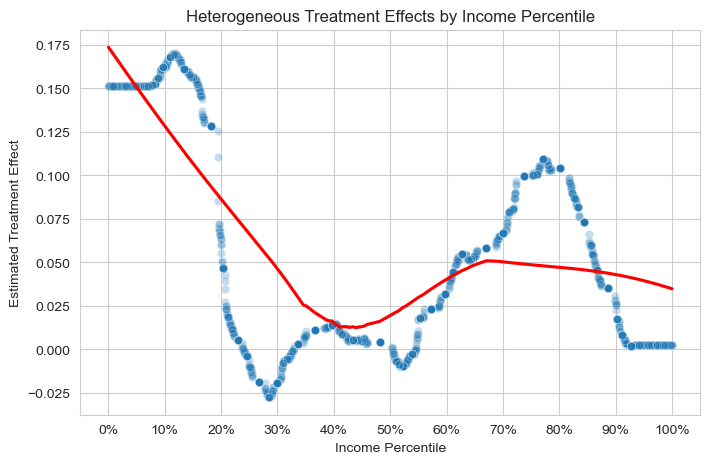

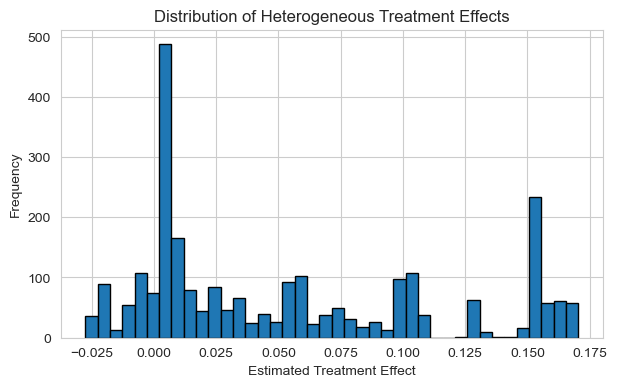

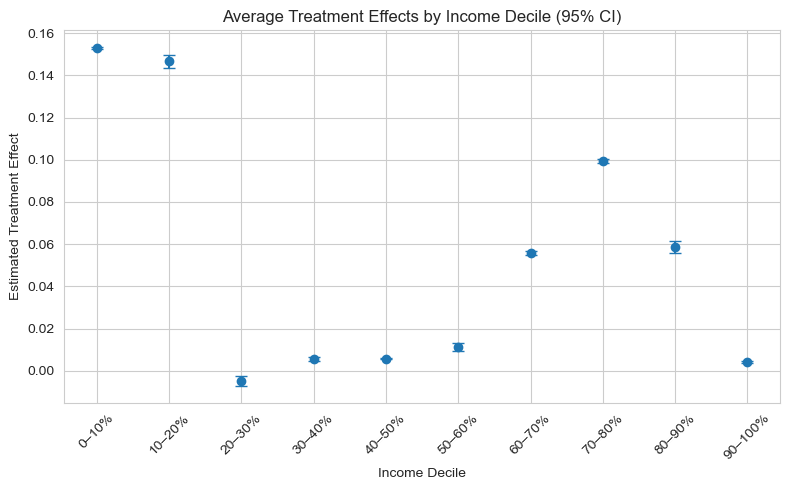

                mean       std    n
Income_Bin                         
Q1 (Low)    0.149720  0.017784  515
Q2          0.000441  0.016132  520
Q3          0.008556  0.011407  518
Q4          0.078740  0.023193  546
Q5 (High)   0.028843  0.030902  472


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("CES_RF_SMT_Dummies.csv")

# Treatment, outcome, weights
T = df["Second_Moment_Treatment"].values
Y = df["lc_w13"].values
W = df["wgt"].values

# Heterogeneity variable (X)
X = df[["Log_Household_Net_Income"]].values

# Controls (Z)
COVARIATES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

Z = df[COVARIATES].values

# -------------------------------
# Nuisance models
# -------------------------------
model_y = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

model_t = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

# -------------------------------
# Causal Forest
# -------------------------------
cf = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    n_estimators=1000,
    min_samples_leaf=50,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

cf.fit(
    Y,
    T,
    X=X,       # heterogeneity driver
    W=Z,       # controls
    sample_weight=W
)

# Individual Conditional Average Treatment Effects (CATEs)
df["CATE_SMT"] = cf.effect(X)

# -------------------------------
# Income Percentiles
# -------------------------------
df["Income_Percentile"] = df["Log_Household_Net_Income"].rank(pct=True) * 100

# -------------------------------
# HTE Plot: Scatter + LOWESS by percentile
# -------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.scatterplot(
    x=df["Income_Percentile"],
    y=df["CATE_SMT"],
    alpha=0.25
)

sns.regplot(
    x=df["Income_Percentile"],
    y=df["CATE_SMT"],
    scatter=False,
    lowess=True,
    color="red"
)

plt.xlabel("Income Percentile")
plt.ylabel("Estimated Treatment Effect")
plt.title("Heterogeneous Treatment Effects by Income Percentile")
plt.xticks(ticks=np.arange(0, 101, 10), labels=[f"{i}%" for i in range(0, 101, 10)])
OUT_PDF1 = "GRF_HTEs.pdf"
plt.savefig(OUT_PDF1, dpi=300)
plt.show()

# -------------------------------
# HTE Histogram
# -------------------------------
plt.figure(figsize=(7, 4))
plt.hist(df["CATE_SMT"], bins=40, edgecolor="black")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.title("Distribution of Heterogeneous Treatment Effects")
OUT_PDF2 = "Histogram.pdf"
plt.savefig(OUT_PDF2, dpi=300)
plt.show()

# -------------------------------
# Decile averages with 95% CI
# -------------------------------
df["Income_Decile"] = pd.qcut(
    df["Income_Percentile"],
    q=10,
    labels=[f"{i*10}–{(i+1)*10}%" for i in range(10)]
)

decile_summary = df.groupby("Income_Decile")["CATE_SMT"].agg(
    mean="mean",
    se=lambda x: x.std() / np.sqrt(len(x))
).reset_index()

plt.figure(figsize=(8, 5))
plt.errorbar(
    x=range(10),
    y=decile_summary["mean"],
    yerr=1.96 * decile_summary["se"],
    fmt="o",
    capsize=4
)

plt.xticks(ticks=range(10), labels=decile_summary["Income_Decile"], rotation=45)
plt.xlabel("Income Decile")
plt.ylabel("Estimated Treatment Effect")
plt.title("Average Treatment Effects by Income Decile (95% CI)")
plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Bin summary for reference (5 bins)
# -------------------------------
df["Income_Bin"] = pd.qcut(
    df["Log_Household_Net_Income"], 
    q=5, 
    labels=["Q1 (Low)", "Q2", "Q3", "Q4", "Q5 (High)"]
)

bin_summary = df.groupby("Income_Bin")["CATE_SMT"].agg(
    mean="mean",
    std="std",
    n="count"
)

print(bin_summary)


In [18]:
import pandas as pd
import numpy as np

# ---- 1) Load data ----
ces = pd.read_csv("CES_RF_SMT_clean.csv")

# ---- 2) Filter for households that received the treatment ----
treated = ces[ces["Second_Moment_Treatment"] == 1].copy()

# ---- 3) Compute changes ----
treated["First_Moment_Change"] = treated["First_Moment_Expectation_Post"] - treated["First_Moment_Expectation_Prior"]
treated["Second_Moment_Change"] = treated["Second_Moment_Post"] - treated["Second_Moment_Prior"]

# ---- 4) Create income deciles ----
treated["Income_Decile"] = pd.qcut(treated["Log_Household_Net_Income"], 10, labels=False) + 1

# ---- 5) Compute average changes by decile ----
results = treated.groupby("Income_Decile")[["First_Moment_Change", "Second_Moment_Change"]].mean().reset_index()

# ---- 6) Optional: print nicely ----
print("Average change in expectations by income decile for treated households:")
print(results)


Average change in expectations by income decile for treated households:
   Income_Decile  First_Moment_Change  Second_Moment_Change
0              1             4.092105              0.952955
1              2             5.805236              0.839830
2              3             3.405153              0.910261
3              4             1.930488              0.841456
4              5             2.454036              0.627307
5              6             3.309526              0.484098
6              7             3.164419              0.379994
7              8             1.110340              0.354742
8              9             0.841230              0.361659
9             10             2.556264              0.587726
